In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, topology, vis, solvers, utils
from pyiga import assemble
#from patchmesh import *
from sksparse.cholmod import cholesky
#from patchmesh3D import *
#from multipatch import *

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def PoissonEstimator(MP,f,uh):
    n = MP.mesh.numpatches
    indicator = np.zeros(n)
    params = {'f': f}
    
    uh_loc = MP.Basis@uh
    
    uh_per_patch = dict()
    
    #residual contribution
    for p, ((kvs, geo), _) in enumerate(MP.mesh.patches):
        
        H = np.linalg.norm([b-a for a,b in geo.bounding_box()])
        #N = tuple(kv.numdofs for kv in kvs)
        uh_per_patch[p] = uh_loc[np.arange(MP.N[p]) + MP.N_ofs[p]]   #cache Spline Function on patch p
        kvs0 = tuple([bspline.KnotVector(kv.mesh, 0) for kv in kvs])
        
        params['uh_func'] = geometry.BSplineFunc(kvs, uh_per_patch[p])
        params['geo'] = geo
        
        indicator[p] = H**2 * np.sum(assemble.assemble('(f + div(grad(uh_func)))**2 * v * dx', kvs0, params))
        
    params = dict()
    #flux contribution
    for i,((p1,b1,_), (p2,b2,_), flip) in enumerate(MP.intfs):
        
        ((kvs1, geo1), _), ((kvs2, geo2), _) = MP.mesh.patches[p1], MP.mesh.patches[p2]
        bdspec1, bdspec2 = [assemble.int_to_bdspec(b1)], [assemble.int_to_bdspec(b2)]
        bkv1, bkv2 = assemble.boundary_kv(kvs1, bdspec1), assemble.boundary_kv(kvs2, bdspec2)
        geo = geo2.boundary(bdspec2)
        params['geo'] = geo
        kv0 = tuple([bspline.KnotVector(kv.mesh, 0) for kv in bkv2])
        H = np.sum(assemble.assemble('v * ds', kv0, params))
        
        params['uh_grad1'] = geometry.BSplineFunc(kvs1, uh_per_patch[p1]).transformed_jacobian(geo1).boundary(bdspec1, flip=flip) #physical gradient of uh on patch 1 (flipped if needed)
        params['uh_grad2'] = geometry.BSplineFunc(kvs2, uh_per_patch[p2]).transformed_jacobian(geo2).boundary(bdspec2)            #physical gradient of uh on patch 2
        #params['uh1'] = geometry.BSplineFunc(kvs1, uh_per_patch[p1]).boundary(bdspec1,flip=flip)
        #params['uh2'] = geometry.BSplineFunc(kvs2, uh_per_patch[p2]).boundary(bdspec2)
        normalflux_jump = np.sum(assemble.assemble('(inner(uh_grad1 - uh_grad2, n) )**2 * v * ds', kv0 ,params))
        #print(normalflux_jump)

        indicator[p1] += 0.5 * H * normalflux_jump
        indicator[p2] += 0.5 * H * normalflux_jump
    
    return np.sqrt(indicator)

def check_coupling(MP, u_):
    u_pp = dict()

    for i,((p1,b1,_), (p2,b2,_), flip) in enumerate(MP.intfs):
        
        ((kvs1,_),_), ((kvs2,_),_) = MP.mesh.patches[p1], MP.mesh.patches[p2]
        bdspec1, bdspec2 = int_to_bdspec(b1), int_to_bdspec(b2)
        (kv1), (kv2) = boundary_kv(kvs1, bdspec1), boundary_kv(kvs2, bdspec2, flip=flip)
        dofs1, dofs2 = assemble.boundary_dofs(kvs1, bdspec1, ravel=True), assemble.boundary_dofs(kvs2, bdspec2, ravel=True, flip=flip)
        
        if p1 not in u_pp:
            u_pp[p1]=MP.global_to_patch(p1) @ u_
        if p2 not in u_pp:
            u_pp[p2]=MP.global_to_patch(p2) @ u_
          
        P = bspline.prolongation(kv1, kv2)
        u1, u2 = u_pp[p1][dofs1], u_pp[p2][dofs2]
        r=norm(u2 - P @ u1)
        
        if r>1e-8:
            return False
    return True

In [3]:
def adaptive(M, f, u, theta=0.9, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    err_est=np.zeros(maxiter)
    #params['u_sol']=u_sol
    #params['ux']=ux
    #params['uy']=uy
    MP = assemble.Multipatch(M, automatch = True)
    
    for iter in range(maxiter):
        print(iter)
        if draw:
            MP.mesh.draw(figsize=(6,6))
            plt.axis('scaled');
            plt.show()
        
        # ---------------------------------------------------------------------
        # SOLVE
        # ---------------------------------------------------------------------
        
        numdofs[iter] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:u})
        #print(bcs)

        # assemble the linear system
        Kh, F = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)
        Mh, u_rhs = MP.assemble_system(vform.mass_vf(2), vform.L2functional_vf(2, physical=True), f=u)

        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A))(LS.b))
        u_ = (cholesky(Mh))(u_rhs)
        #print(check_coupling(MP,u_))
        
        eh=uh-u_
        L2err[iter] = sqrt(eh.T@Mh@eh)
        H1err[iter] = sqrt(eh.T@Kh@eh + L2err[iter]**2)
        
        # ---------------------------------------------------------------------
        # ESTIMATE AND REFINE
        # ---------------------------------------------------------------------
        
        if iter < maxiter-1:
            start=time.time()
            err_ind = PoissonEstimator(MP,f,uh)
            err_est[iter] = norm(err_ind)
            marked_patches = doerfler_marking(err_ind, theta)
            end = time.time()
            print("Estimate and Marking took " + str(end - start) + " seconds.")
            
            marked_patches = {p:None for p in marked_patches}
            #print(MP.numdofs)
            start = time.time()
            M.split_patches(patches=marked_patches)
            end = time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            
            start=time.time()
            MP = assemble.Multipatch(M, automatch = True)
            end = time.time()
            print("")
            #MP.patch_refine(patches=marked_patches, return_prol=False)
            #MP.mesh.draw(patch_idx=True)
            #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]
        

    # restrict solution to each individual patch
    #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]

    #for (uh, ((kvs, geo),_)) in zip(uh, MP.mesh.patches):
        #vis.plot_field(uh, geo, vmin=plotrange[0], vmax=plotrange[1])
    #plt.axis('scaled')
    #plt.colorbar();
    
    return uh, numdofs, L2err, H1err, err_est

def uniform(M, f, u, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    MP = assemble.Multipatch(M, automatch = True)
    
    for iter in range(maxiter):
        print(iter)
        if draw:
            MP.mesh.draw(figsize=(6,6))
            plt.axis('scaled');
            plt.show()
            
        numdofs[iter] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:u})
        #print(bcs)

        # assemble the linear system
        Kh, F = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)
        Mh, u_rhs = MP.assemble_system(vform.mass_vf(2), vform.L2functional_vf(2, physical=True), f=u)

        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A))(LS.b))
        u_ = (cholesky(Mh))(u_rhs)
        #print(check_coupling(MP,u_))
        
        eh=uh-u_
        L2err[iter] = sqrt(eh.T@Mh@eh)
        H1err[iter] = sqrt(eh.T@Kh@eh + L2err[iter]**2)
            
        if iter < maxiter-1:
            start=time.time()
            M.refine()
            end=time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            MP = assemble.Multipatch(M, automatch = True)
    MP.plot(uh)
        
    return uh, numdofs, L2err, H1err
            

In [4]:
def doerfler_marking(errors, theta=0.9):
    """Given a list of errors, return a minimal list of indices such that the indexed
    errors have norm of at least theta * norm(errors)."""
    ix = np.argsort(errors)
    total = norm(errors)
    running = []
    marked = []
    for i in reversed(ix):
        running.append(errors[i])
        marked.append(i)
        if norm(running) >= theta * total:
            break
    return marked

In [5]:
#Geometries
def Lshape(deg, N):
 
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.unit_square().translate((-1,0)),
        geometry.unit_square().translate((-1,-1)),
        geometry.unit_square().translate((0,-1))
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)
    return M

In [6]:
def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(r, phi%(2*pi))
def u(x,y):
    r, phi = cart2pol(x,y)
    return r**(2/3)*sin(2*(phi-pi/2)/3)
# def ux(x,y):
#     r, phi = cart2pol(x,y)
#     return -2./3*r**(-1./3)*sin(phi/3)
# def uy(x,y):
#     r, phi = cart2pol(x,y)
#     return 2./3*r**(-1./3)*cos(phi/3)

f=lambda x,y: 0

In [7]:
plt

<module 'matplotlib.pyplot' from '/home/wolfman/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

0


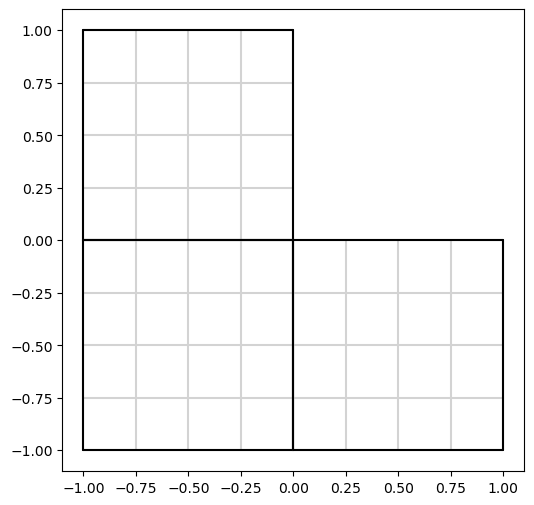

/tmp/ipykernel_6229/3681292613.py:113: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh = LS.complete((cholesky(LS.A))(LS.b))


Refinement took 0.0002052783966064453 seconds.
1


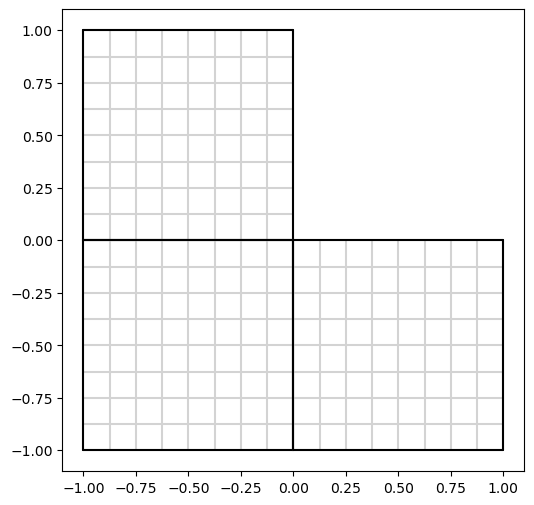

Refinement took 0.0002512931823730469 seconds.
2


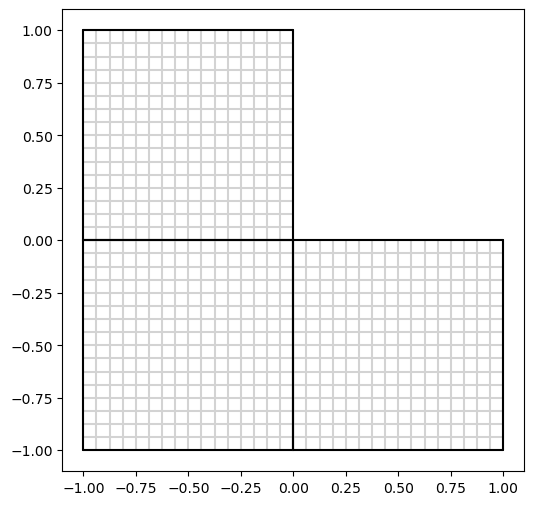

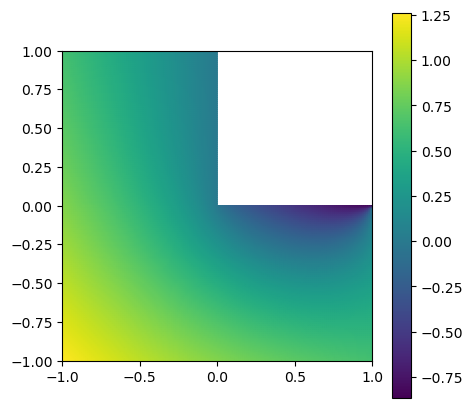

In [8]:
M = Lshape(4,4)
uh, numdofs, L2err, H1err = uniform(M,f,u, maxiter=3, draw=True)

0


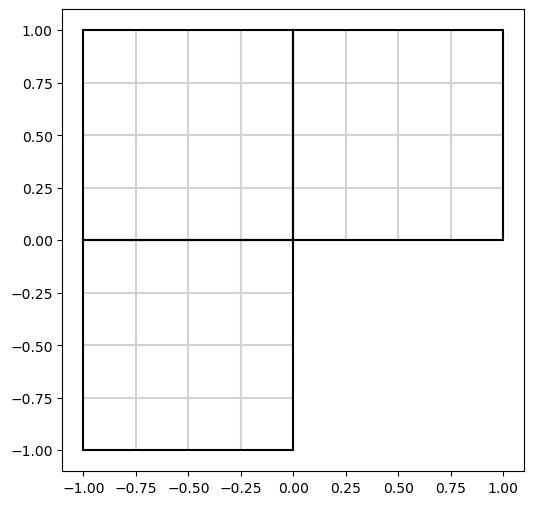

/tmp/ipykernel_10571/790531011.py:38: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh = LS.complete((cholesky(LS.A))(LS.b))


Estimate and Marking took 0.030427217483520508 seconds.
Refinement took 0.005829572677612305 seconds.

1


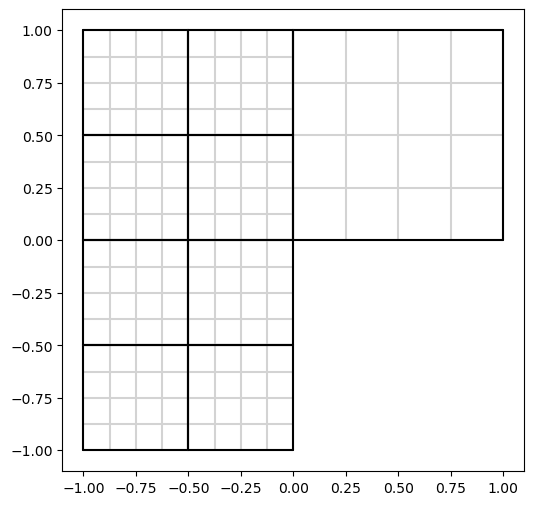

Estimate and Marking took 0.13150429725646973 seconds.
Refinement took 0.006703853607177734 seconds.

2


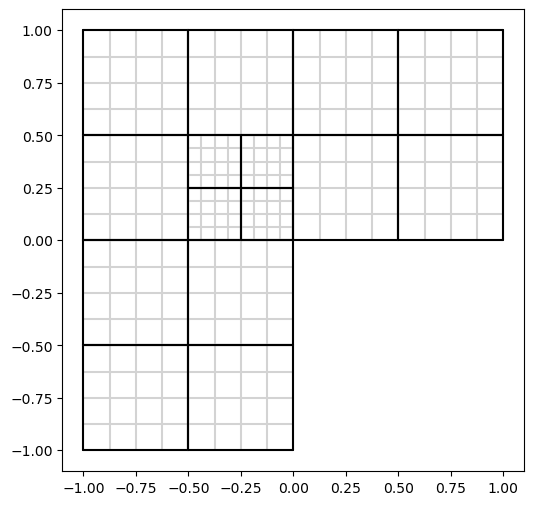

Estimate and Marking took 0.2429194450378418 seconds.
Refinement took 0.007288694381713867 seconds.

3


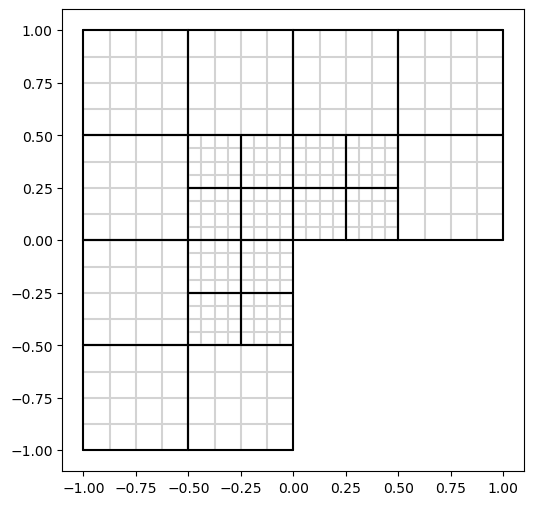

Estimate and Marking took 0.3546440601348877 seconds.
Refinement took 0.008229255676269531 seconds.

4


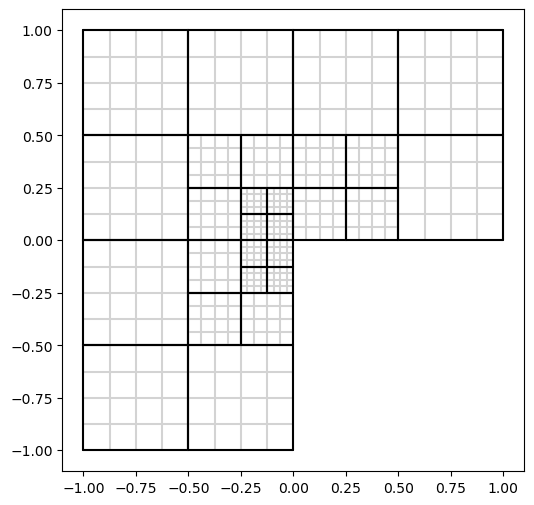

Estimate and Marking took 0.49013209342956543 seconds.
Refinement took 0.00910043716430664 seconds.

5


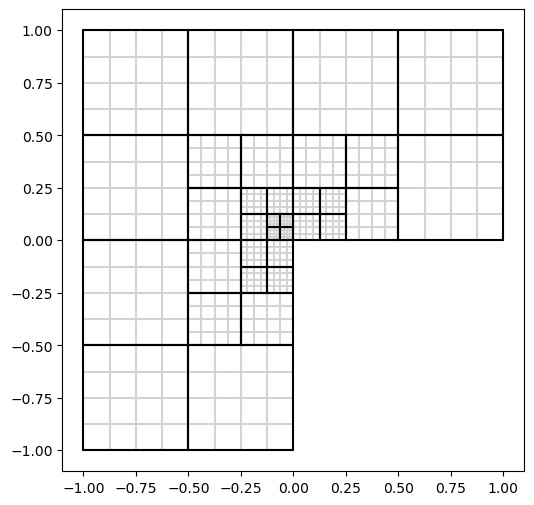

Estimate and Marking took 0.6858699321746826 seconds.
Refinement took 0.009809494018554688 seconds.

6


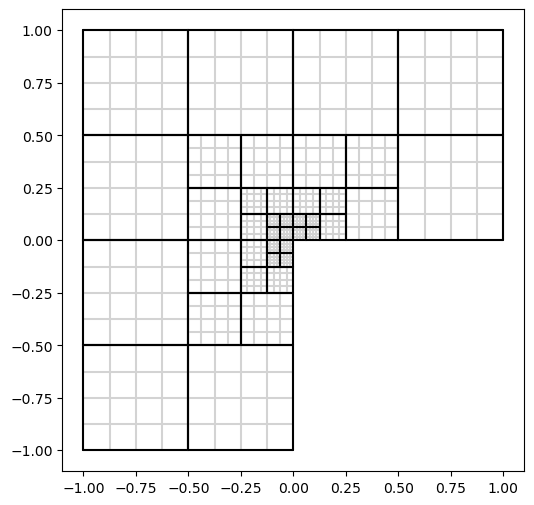

Estimate and Marking took 0.7092044353485107 seconds.
Refinement took 0.01074671745300293 seconds.

7


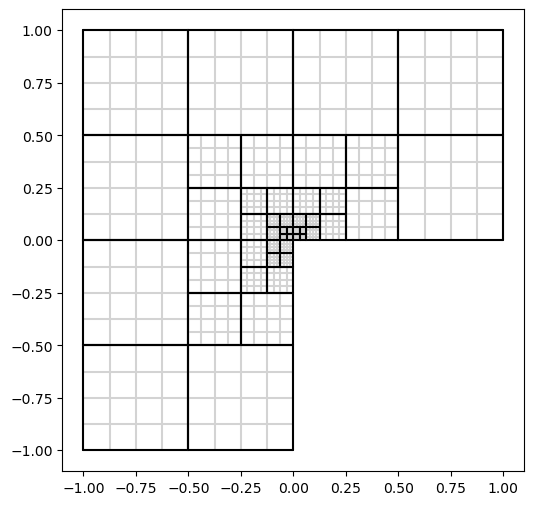

Estimate and Marking took 0.8328442573547363 seconds.
Refinement took 0.0114593505859375 seconds.

8


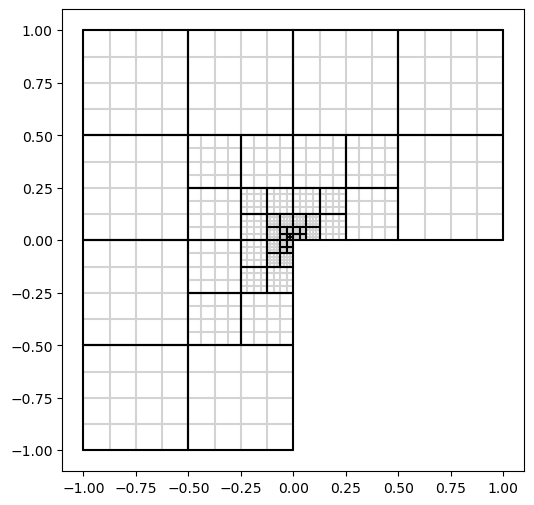

Estimate and Marking took 0.9461476802825928 seconds.
Refinement took 0.012361288070678711 seconds.

9


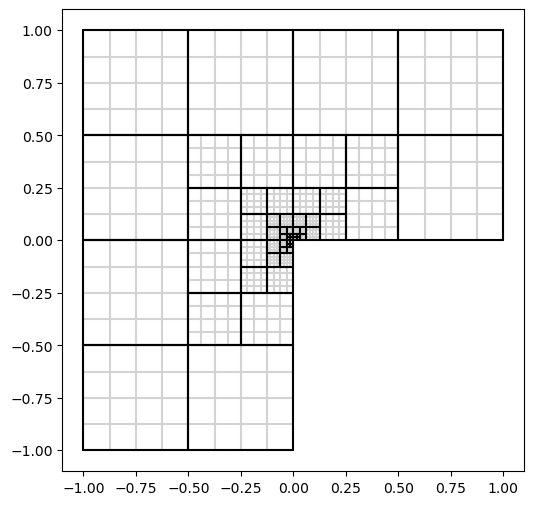

Estimate and Marking took 1.1160860061645508 seconds.
Refinement took 0.013043403625488281 seconds.

10


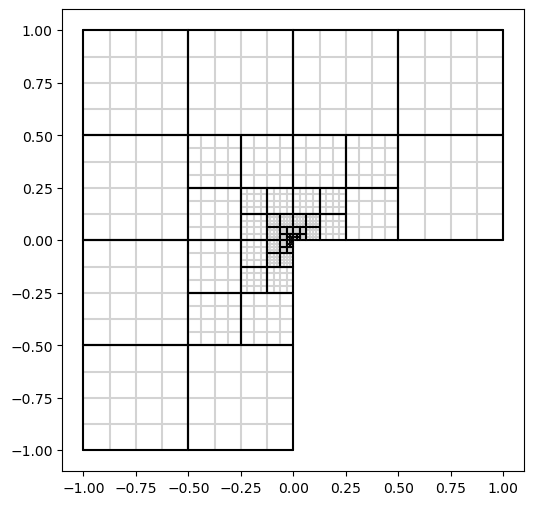

Estimate and Marking took 1.2746772766113281 seconds.
Refinement took 0.013850212097167969 seconds.

11


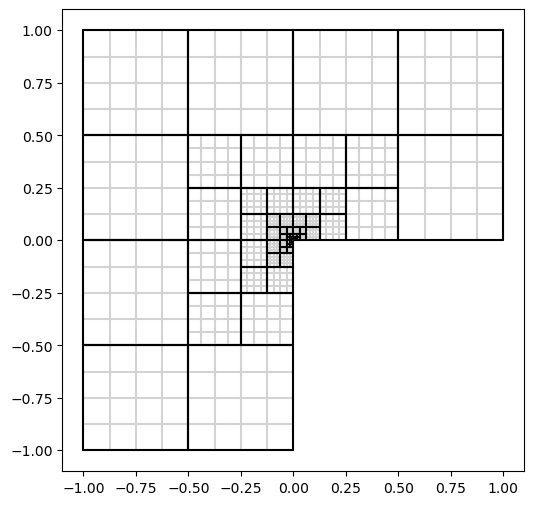

Estimate and Marking took 1.3129210472106934 seconds.
Refinement took 0.014622688293457031 seconds.

12


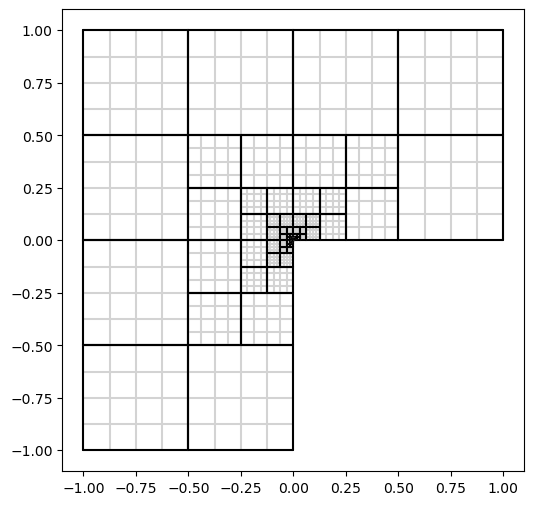

Estimate and Marking took 1.4135468006134033 seconds.
Refinement took 0.015531778335571289 seconds.

13


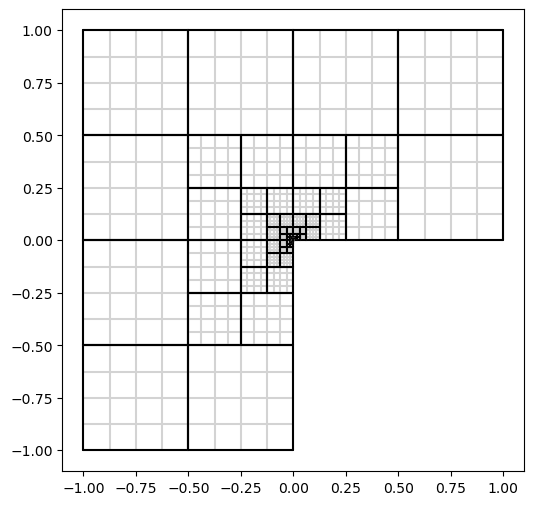

Estimate and Marking took 1.6006104946136475 seconds.
Refinement took 0.016473770141601562 seconds.

14


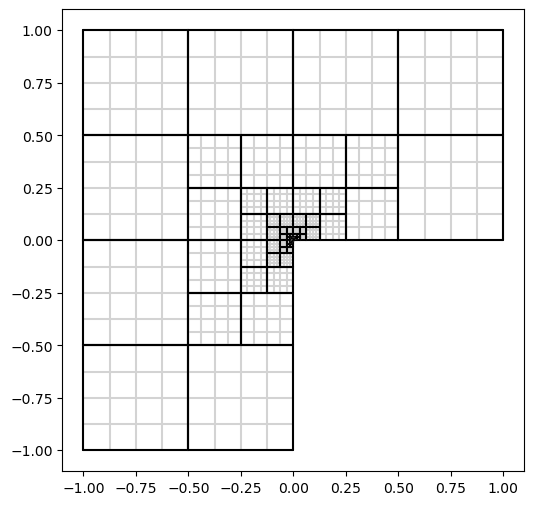

Estimate and Marking took 1.6715798377990723 seconds.
Refinement took 0.017013072967529297 seconds.

15


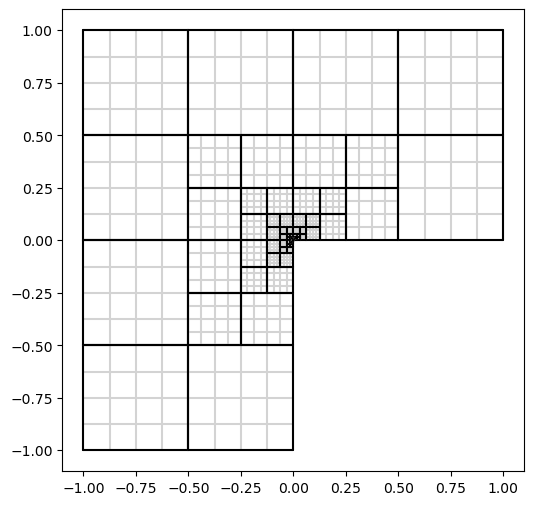

Estimate and Marking took 1.8913829326629639 seconds.
Refinement took 0.017990827560424805 seconds.

16


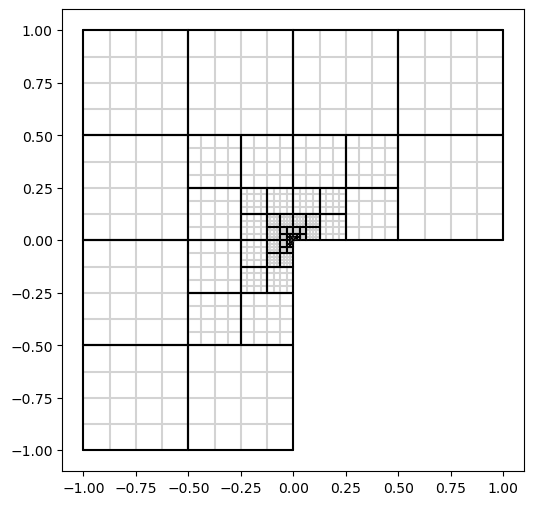

Estimate and Marking took 1.967170000076294 seconds.
Refinement took 0.018660783767700195 seconds.

17


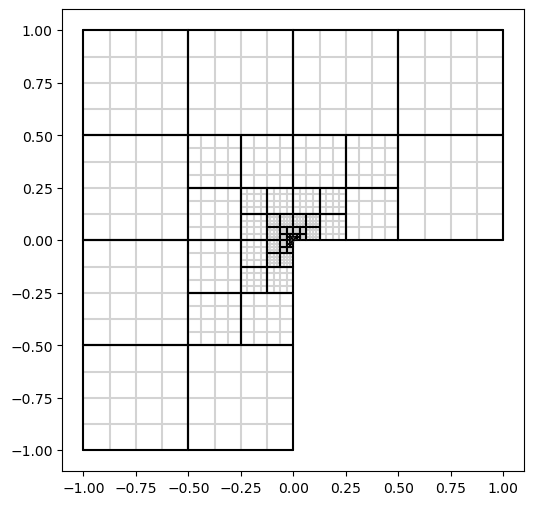

Estimate and Marking took 2.124730348587036 seconds.
Refinement took 0.01981639862060547 seconds.

18


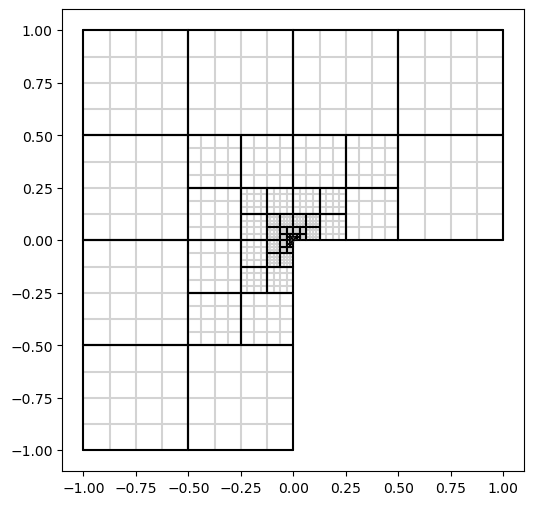

Estimate and Marking took 2.4017932415008545 seconds.
Refinement took 0.024034976959228516 seconds.

19


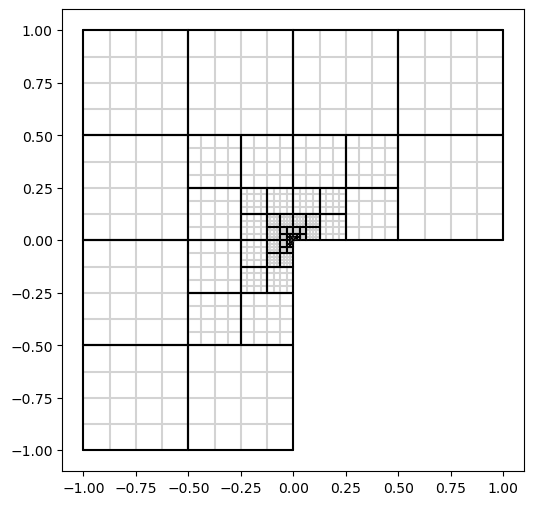

Estimate and Marking took 2.2504632472991943 seconds.
Refinement took 0.021236896514892578 seconds.

20


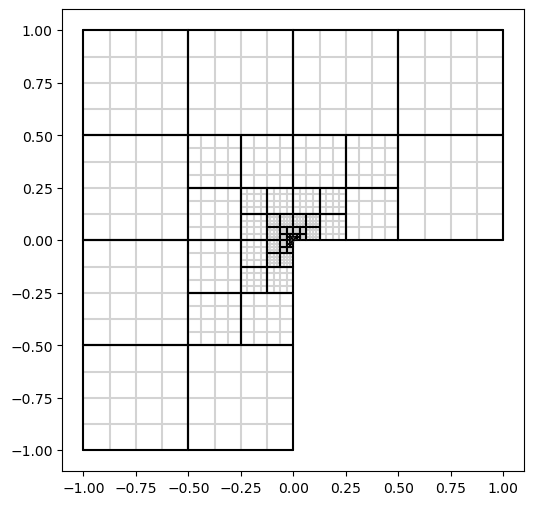

Estimate and Marking took 2.4238553047180176 seconds.
Refinement took 0.021978378295898438 seconds.

21


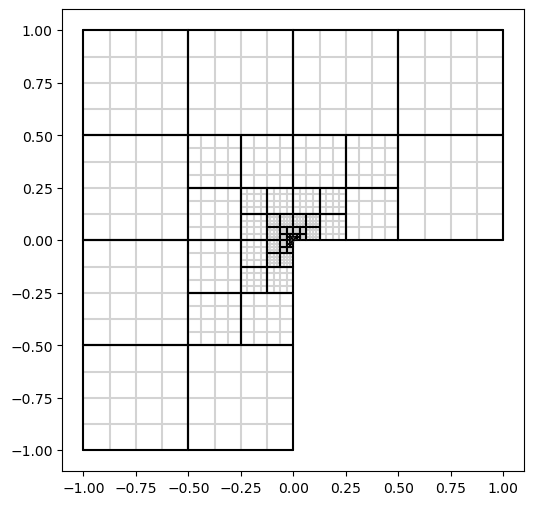

Estimate and Marking took 2.5377213954925537 seconds.
Refinement took 0.02295708656311035 seconds.

22


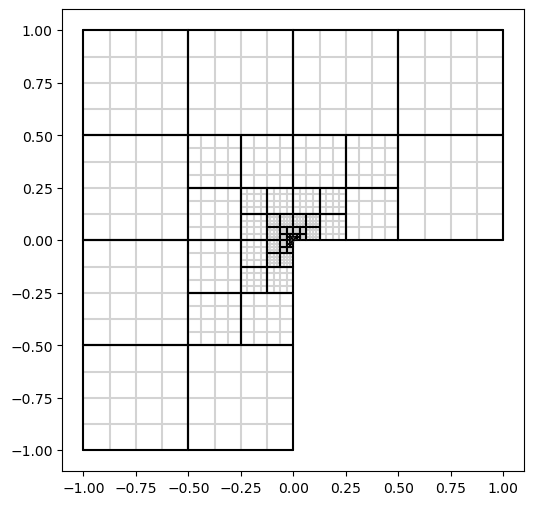

Estimate and Marking took 2.636812925338745 seconds.
Refinement took 0.023494482040405273 seconds.

23


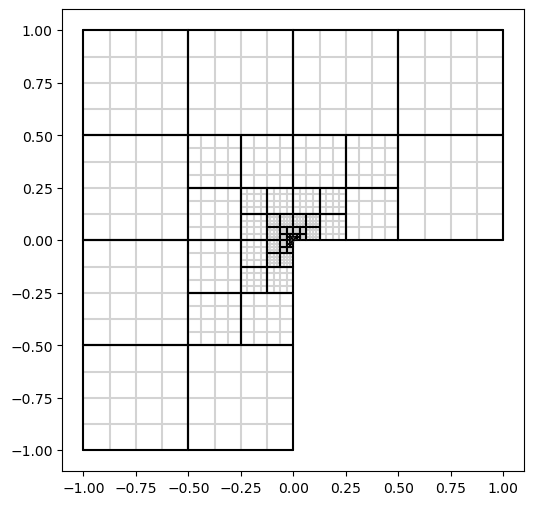

Estimate and Marking took 2.744476079940796 seconds.
Refinement took 0.024314403533935547 seconds.

24


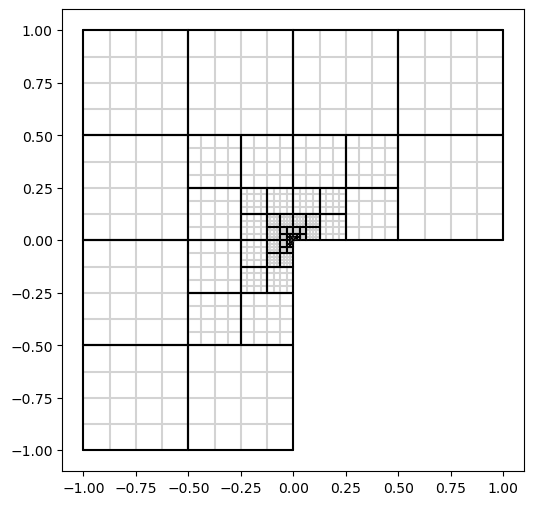

Estimate and Marking took 2.845611810684204 seconds.
Refinement took 0.037981510162353516 seconds.

25


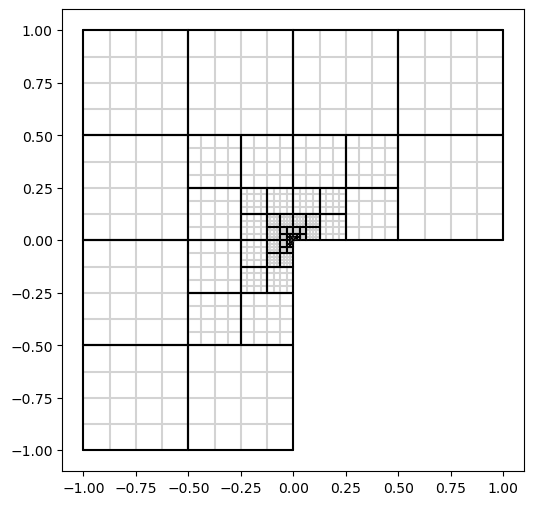

Estimate and Marking took 3.07303524017334 seconds.
Refinement took 0.04022336006164551 seconds.

26


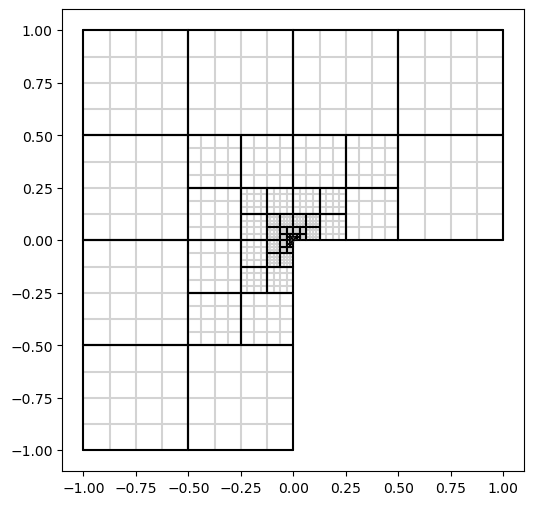

Estimate and Marking took 3.2416090965270996 seconds.
Refinement took 0.042986154556274414 seconds.

27


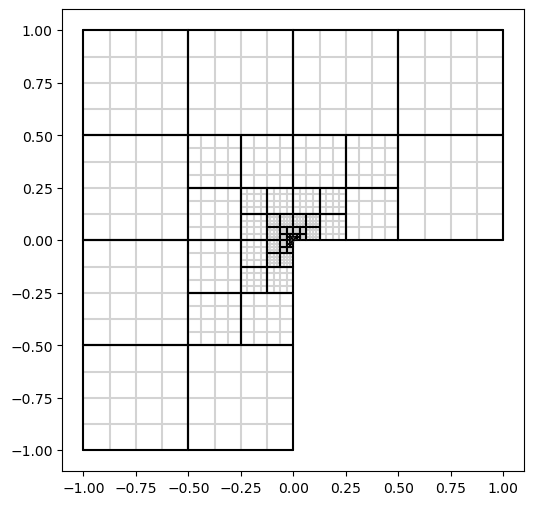

Estimate and Marking took 3.391742706298828 seconds.
Refinement took 0.04328036308288574 seconds.

28


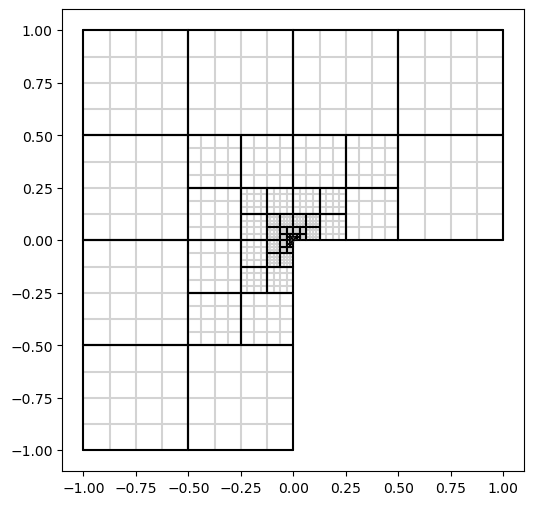

Estimate and Marking took 3.570993661880493 seconds.
Refinement took 0.10729098320007324 seconds.

29


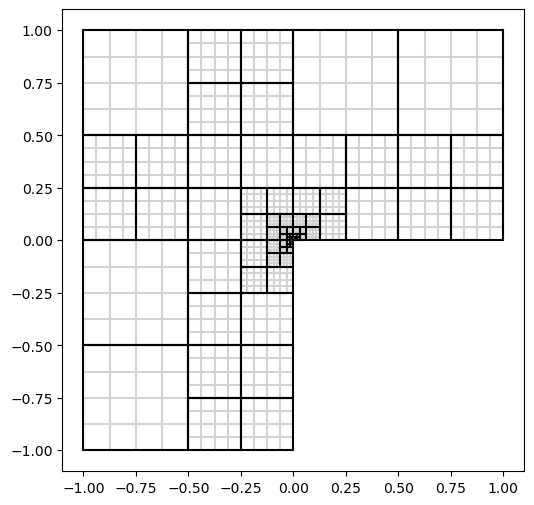

Estimate and Marking took 3.95074462890625 seconds.
Refinement took 0.15202021598815918 seconds.

30


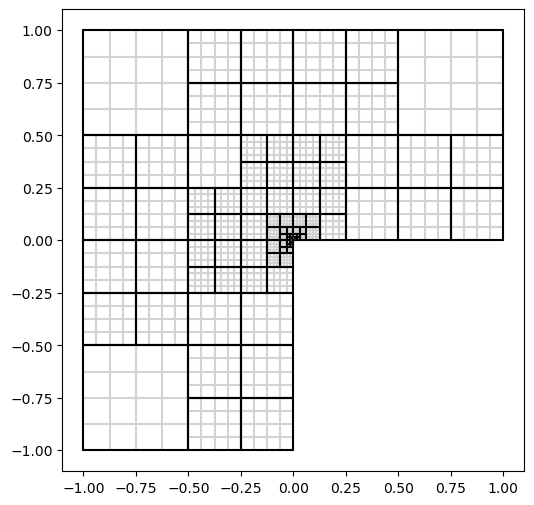

Estimate and Marking took 4.485585451126099 seconds.
Refinement took 0.1655595302581787 seconds.

31


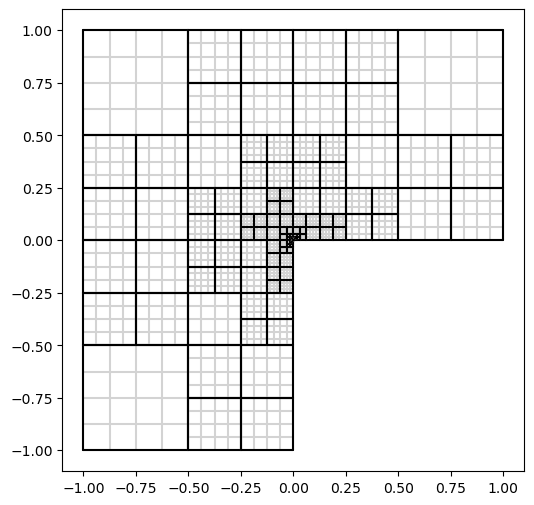

Estimate and Marking took 4.9937050342559814 seconds.
Refinement took 0.22672486305236816 seconds.

32


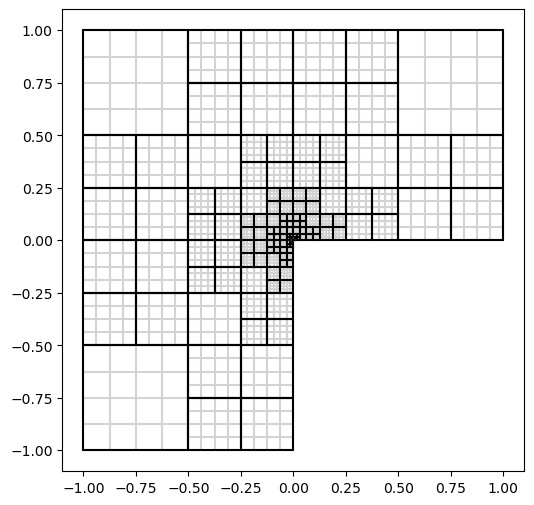

Estimate and Marking took 5.6242523193359375 seconds.
Refinement took 0.289762020111084 seconds.

33


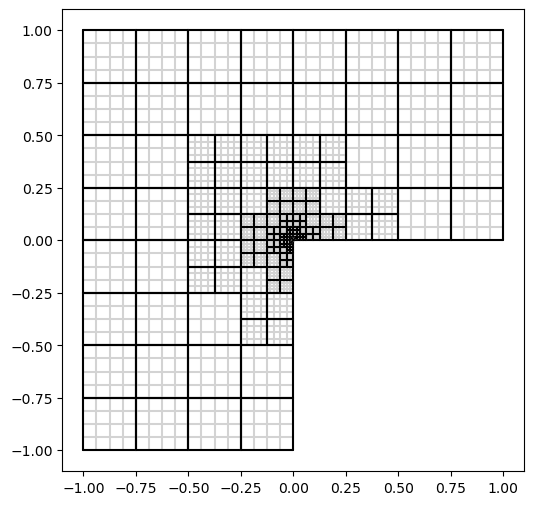

Estimate and Marking took 6.3072898387908936 seconds.
Refinement took 0.37517595291137695 seconds.

34


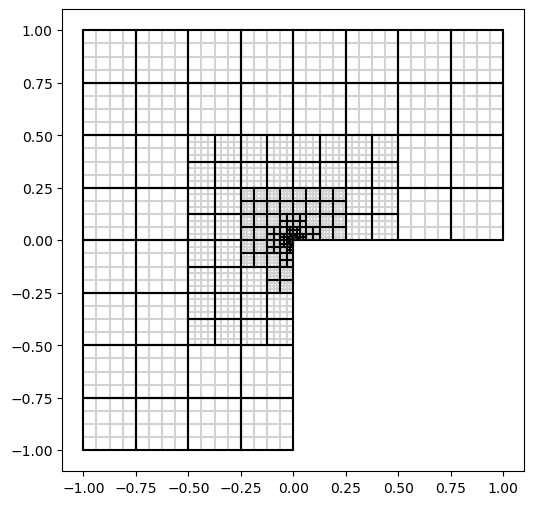

Estimate and Marking took 7.1741321086883545 seconds.
Refinement took 0.5944344997406006 seconds.

35


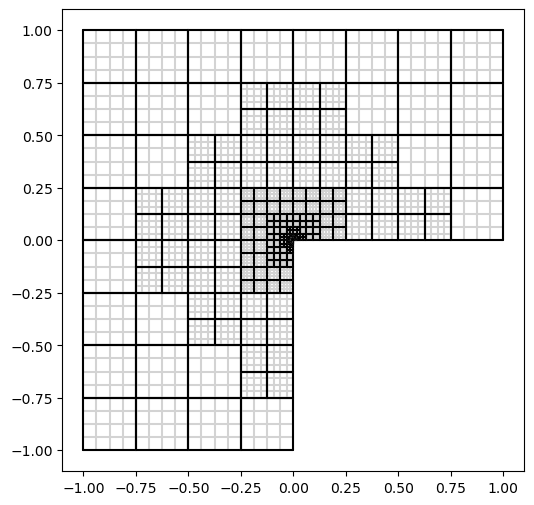

Estimate and Marking took 8.365577220916748 seconds.
Refinement took 0.8439469337463379 seconds.

36


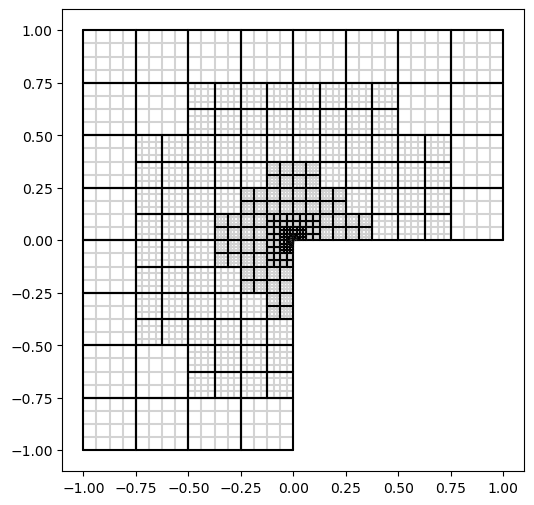

Estimate and Marking took 9.900424480438232 seconds.
Refinement took 1.259760856628418 seconds.

37


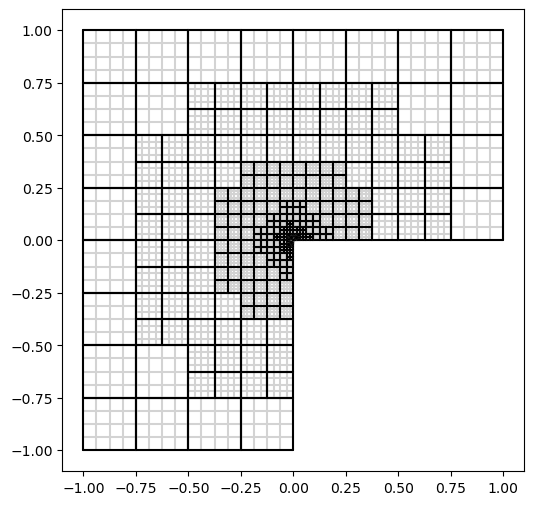

Estimate and Marking took 11.87709379196167 seconds.
Refinement took 1.8079993724822998 seconds.

38


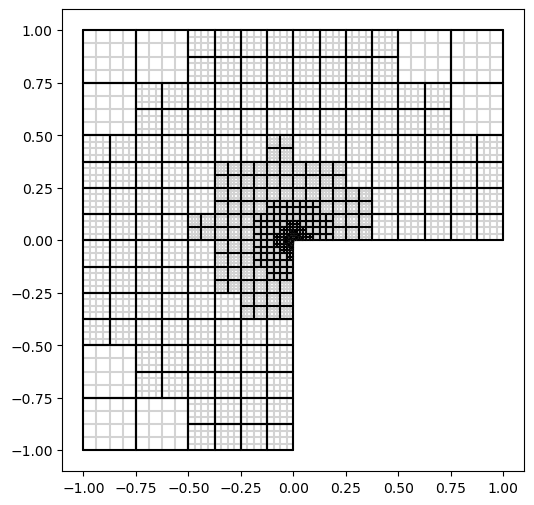

Estimate and Marking took 14.177429676055908 seconds.
Refinement took 2.506288766860962 seconds.

39


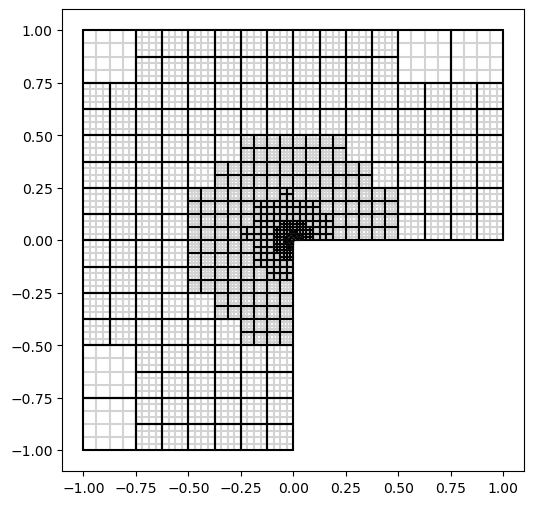

In [10]:
M = Lshape(4,4)
uh_a, numdofs_a, L2err_a, H1err_a, err_est = adaptive(M, f, u, draw=True, maxiter=40)